# Project 01 - Color Compression

## Thông tin sinh viên

- Họ và tên: Đinh Xuân Khương
- MSSV: 23127398
- Lớp: 23CLC04

## Import các thư viện liên quan

In [46]:
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image

## Helper functions

In [47]:
def read_img(img_path):
    '''
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    '''

    try: 
        img = Image.open(img_path)
    except FileNotFoundError:
        print("File not found!")
    img.convert("RGB")  
    img = np.array(img)  
    return img         


def show_img(img_2d):
    '''
    Show image

    Parameters
    ----------
    img_2d : numpy.ndarray
        Image (2D)
    '''
    # YOUR CODE HERE
    plt.imshow(img_2d)
    plt.axis("off")
    plt.show()
    


def save_img(img_2d, img_path):
    '''
    Save image to img_path

    Parameters
    ----------
    img_2d : numpy.ndarray
        Image (2D)
    img_path : str
        Path of image
    '''
    # YOUR CODE HERE
    ask_requirements = """
    Please choose the image export format:
    (Type "1" or "2" or "3")
    (1): PDF
    (2): PNG
    (3): Both PDF and PNG
    """
    choice = input(ask_requirements)
    while choice not in ['1', '2', '3']:
        print("Invalid choice. Please enter 1, 2, or 3.")
        choice = input(ask_requirements)
    choice = int(choice)
    
    # Normalize float image if necessary
    if np.issubdtype(img_2d.dtype, np.floating):
        img_2d = np.clip(img_2d, 0.0, 1.0)  # ensure in [0,1]
        img_2d = (img_2d * 255).astype(np.uint8)

    elif img_2d.dtype != np.uint8:
        img_2d = img_2d.astype(np.uint8)

    # Convert NumPy array to PIL image
    img = Image.fromarray(img_2d)

    # Convert to RGB if saving to PDF (some readers require it)
    img_rgb = img.convert("RGB")
    if img_path == "":
        img_path = "./"
    img_path = img_path if img_path.endswith("/") else img_path + "/"
    if choice == 1:
        img_rgb.save(img_path + "compressed_image.pdf", "PDF")
    elif choice == 2:
        img.save(img_path + "compressed_image.png", "PNG")
    elif choice == 3:
        img.save(img_path + "compressed_image.png", "PNG")
        img_rgb.save(img_path + "compressed_image.pdf", "PDF")
    


def convert_img_to_1d(img_2d):
    '''
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : numpy.ndarray
        Image (2D)

    Returns
    -------
        Image (1D)
    '''
    h, w, c = img_2d.shape  # Get the shape of the image
    img_1d = img_2d.reshape(h * w, c)  # Flatten the image
    return img_1d  # Return the flattened image
    
def kmeans(img_1d, k_clusters, max_iter, init_centroids='random'):
    """
    K-Means algorithm.

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image in uint8 format
    k_clusters : int
        Number of clusters
    max_iter : int
        Maximum number of iterations
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 1 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster in uint8 format
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    """
    img_1d = img_1d.astype(np.float32) / 255.0
    centroids = choose_centroids(init_centroids, img_1d, k_clusters)

    # Precompute norms of image pixels
    img_norms = np.sum(img_1d ** 2, axis=1, keepdims=True)  # shape: (n_pixels, 1)

    for _ in range(max_iter):
        # Compute centroid norms
        cent_norms = np.sum(centroids ** 2, axis=1)  # shape: (k_clusters,)
        # Compute inner product between pixels and centroids
        inner_products = img_1d @ centroids.T  # shape: (n_pixels, k_clusters)

        # Use the formula: ||x - c||^2 = ||x||^2 - 2x^T c + ||c||^2
        dists_squared = img_norms - 2 * inner_products + cent_norms  # broadcast automatically
        labels = np.argmin(dists_squared, axis=1)

        # Update centroids
        new_centroids = np.zeros_like(centroids)
        counts = np.bincount(labels, minlength=k_clusters)
        for d in range(img_1d.shape[1]):
            np.add.at(new_centroids[:, d], labels, img_1d[:, d])
        
        # Handle empty clusters
        non_empty = counts > 0
        new_centroids[non_empty] /= counts[non_empty, None]
        new_centroids[~non_empty] = centroids[~non_empty]

        if np.all(np.abs(centroids - new_centroids) < 1e-3):
            break
        centroids = new_centroids

    centroids = (centroids * 255).astype(np.uint8)
    return centroids, labels


def generate_2d_img(img_2d_shape, centroids, labels):
    '''
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    '''

    # YOUR CODE HERE
    new_img = np.zeros(img_2d_shape)
    for i in range(img_2d_shape[0]):
        for j in range(img_2d_shape[1]):
            new_img[i, j] = centroids[labels[i * img_2d_shape[1] + j]]

    return new_img.astype(np.uint8)

# Your additional functions here
    
def choose_centroids(init_centroids, img_1d, k_clusters):
    """
    Choose centroids for K-means clustering.

    Parameters
    ----------
    init_centroids : str
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 1 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image, assumed to be normalized to [0, 1]
    k_clusters : int
        Number of clusters

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster in float32, normalized to [0, 1]
    """
    if init_centroids == 'random':
        # Initialize random centroids in [0, 1] range
        centroids = np.random.uniform(0, 1, size=(k_clusters, img_1d.shape[1])).astype(np.float32)
        # Ensure unique centroids by regenerating duplicates
        while np.unique(centroids, axis=0).shape[0] < k_clusters:
            duplicate_indices = np.where((centroids[:, None] == centroids).all(axis=2).sum(axis=1) > 1)[0]
            if len(duplicate_indices) > 0:
                centroids[duplicate_indices] = np.random.uniform(0, 1, size=(len(duplicate_indices), img_1d.shape[1])).astype(np.float32)
    elif init_centroids == 'in_pixels':
        # Select unique random pixels from the image
        random_indices = np.random.choice(img_1d.shape[0], size=k_clusters, replace=False)
        centroids = img_1d[random_indices].astype(np.float32)
    else:
        raise ValueError("init_centroids must be 'random' or 'in_pixels'")

    return centroids




## Your tests

## Main FUNCTION

In [ ]:
# YOUR CODE HERE
def main():
    image_path = input("Please type your image path:")
    user_image = read_img(image_path)
    print("Input image:")
    show_img(user_image)
    k = input("Please choose K for running Kmeans: ")
    img_1d = convert_img_to_1d(user_image)
    max_iter = int(input("Please enter the maximum number of iterations (default is 10000): ") or 10000)
    centroids_type = input("Please choose the method for initializing centroids ('random' or 'in_pixels'): ")
    if (centroids_type != 'random' and centroids_type != 'in_pixels'):
        print("Invalid choice for centroids initialization. Defaulting to 'random'.")
        centroids_type = 'random'
    centroids, labels = kmeans(img_1d, int(k), max_iter, centroids_type)
    compressed_image = generate_2d_img(user_image.shape, centroids, labels)
    
    print(f"Compressed image with K = {k}:")
    show_img(compressed_image)
    save_path = input("Please enter the path to save the compressed image (default is current path, just hit 'enter' for default choosing): ")
    save_img(compressed_image, save_path)
    return 
    


Input image:


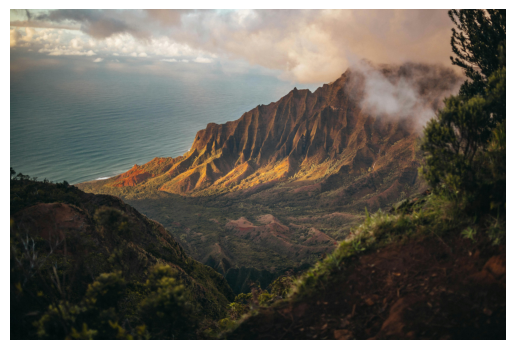

Compressed image with K = 7:


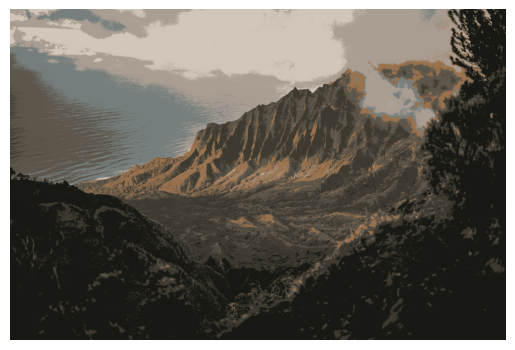

In [49]:
# Call main function

if __name__ == "__main__":
    main()